# Two-pool model from Barker *et al.* (2020)

In [1]:
pwd()

"/home/kkganko/6.337/18.337-Project-SP2023/Stochastic Diffeqs"

In [2]:
dir_contents = readdir(".")

14-element Vector{String}:
 ".ipynb_checkpoints"
 "Birth-Death.ipynb"
 "BirthDeathFlux.ipynb"
 "Fitting Data to SDE Practice.ipynb"
 "Lux Tutorial.ipynb"
 "MWE Birth-Death-KG.ipynb"
 "MWE Birth-Death.ipynb"
 "MWE Two-Pool-KG.ipynb"
 "Manifest.toml"
 "NN_sde_combined.png"
 "Neural ODE Practice.ipynb"
 "Neural SDE Practice.ipynb"
 "Project.toml"
 "Stochastic Diffeq Practice.ipynb"

In [3]:
dir_contents_parent = readdir("..")

12-element Vector{String}:
 ".git"
 ".gitignore"
 ".ipynb_checkpoints"
 "LICENSE"
 "Manifest.toml"
 "Min working example.ipynb"
 "Project.toml"
 "README.md"
 "Stochastic Diffeqs"
 "generate-project-toml.ipynb"
 "test_lux-componentarrays.ipynb"
 "test_python.ipynb"

In [4]:
# # If Project.toml and Manifest.toml exist, remove them to start a completely fresh installation of packages and dependencies.
# # This is equivalent to uninstalling all packages in the current environment. 
# # Why? B/c if you don't start from a clean plate, and you have previous package dependency installation that were unspecified 
# # below in their version number, then dependencies may conflict.

# # get contents of working directory
# dir_contents = readdir(".")
# println(dir_contents)
# if "Manifest.toml" in dir_contents
#     rm("Manifest.toml")
#     println("Removed Manifest.toml from $(pwd()).")
# end
# if "Project.toml" in dir_contents
#     rm("Project.toml")
#     println("Removed Project.toml from $(pwd()).")
# end

# # Check file contents in project directory, copy over Project.toml and Manifest.toml if they exist.
# # If they don't exist, create them with generate-project-toml.ipynb.
# parentdir_contents = readdir("..")
# parentdir_info = stat("..")
# # copy contents from parent to working directory 
# if "Manifest.toml" in parentdir_contents
#     cp("../Manifest.toml", joinpath(pwd(),"Manifest.toml"))
#     println("Manifest.toml copy from project dir to $(pwd()) successful.")
# else
#     println("No Manifest.toml in parent directory.")
# end
# if "Project.toml" in parentdir_contents
#     cp("../Project.toml", joinpath(pwd(),"Project.toml"))
#     println("Project.toml copy from project dir to $(pwd()) successful.")
# else
#     println("No Project.toml in parent directory.")
# end

In [5]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`


In [6]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [b0b7db55] ComponentArrays v0.13.12
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.91
  [587475ba] Flux v0.13.16
  [f6369f11] ForwardDiff v0.10.35
  [bd48cda9] GraphRecipes v0.5.12
  [86223c79] Graphs v1.8.0
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b2108857] Lux v0.4.53
  [429524aa] Optim v1.7.5
  [7f7a1694] Optimization v3.14.1
  [253f991c] OptimizationFlux v0.1.4
  [91a5bcdd] Plots v1.38.11
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.31.0
  [e88e6eb3] Zygote v0.6.61


In [7]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DifferentialEquations.DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff
using Graphs
using GraphRecipes
using RecursiveArrayTools
using Lux

# Define SDE model: Change to Non-mutating form to aid Zygote in backprop!

See for recommendations: https://discourse.julialang.org/t/zygote-and-sde-failure-cannot-differentiate-through-lux-nn/84177.

In [8]:
# set up problem: initial conditions, params, solver hyperparams
datasize = 201
tspan = (0.0, 10.0)
tsteps = range(tspan[1], tspan[2], length = datasize)
NOISE_STRUCT = zeros(Float64,2,4)

2×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [9]:
# new implementation that can handle Dual numbers for autodiff, i.e., with ForwardDiff.Dual
# some algs tested below require this functionality: ImplicitEulerHeun especially
# also added Lux.Tracker.TrackedReal for du, u, and Lux.Tracker.TrackedArray for params (which comes as matrices in NNs)
# function trueSDEfunc!(
#         du::Vector{T1},
#         u::Vector{T2},
#         p::Vector{T3},
#         t::Float64
# ) where {
#     T1<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T2<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T3<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedArray}
#     }
function trueSDEfunc!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
    end
end

# # non-mutating version
# function trueSDEfunc(u,p,t)
#     @inbounds begin
#         # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
#         R1 = exp(p[1])*u[1]
#         R2 = exp(p[2])*u[2]
#         R3 = exp(p[3])*u[1]
#         R4 = exp(p[4])*u[2]
#         du1 = R4-R1-R3
#         du2 = R3-R2-R4
#         return [du1,du2]
#     end
# end

# new implementation that can't handle Dual numbers for autodiff...
# also added Lux.Tracker.TrackedReal for du, u, and Lux.Tracker.TrackedArray for params (which comes as matrices in NNs)
# function true_noise_func!(
#         du::Matrix{T1},
#         u::Vector{T2},
#         p::Vector{T3},
#         t::Float64
# ) where {
#     T1<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T2<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T3<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedArray}
#     }
function true_noise_func!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1, 1] = -sqrt(R1)
        du[1, 3] = -sqrt(R3)
        du[1, 4] = sqrt(R4)
        du[2, 2] = -sqrt(R2)
        du[2, 3] = sqrt(R3)
        du[2, 4] = -sqrt(R4)
    end
end

# # non-mutating version
# function true_noise_func(u,p,t)
#     @inbounds begin
#         # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
#         R1 = exp(p[1])*u[1]
#         R2 = exp(p[2])*u[2]
#         R3 = exp(p[3])*u[1]
#         R4 = exp(p[4])*u[2]
#         du = NOISE_STRUCT
#         du[1, 1] = -sqrt(R1)
#         du[1, 3] = -sqrt(R3)
#         du[1, 4] = sqrt(R4)
#         du[2, 2] = -sqrt(R2)
#         du[2, 3] = sqrt(R3)
#         du[2, 4] = -sqrt(R4)
#         return du
#     end
# end

# callbacks
# terminate_condition(u,t,integrator) = (u[1] < 0.0) || (u[2] < 0.0)
# affect_solver!(integrator) = terminate!(integrator, ReturnCode.Terminated) # can't use symbols for retcodes anymore, need to reference directly from ReturnCode object
# cb_stop_solver = DiscreteCallback(terminate_condition,affect_solver!)
# cbs = CallbackSet(cb_stop_solver)

# reflecting condition, helps stabilize ensemble results
# see https://stackoverflow.com/questions/69049991/simulating-a-reflecting-boundary-sdeproblem
function affect!(integrator)
    if integrator.u[2] < 0
        integrator.u[2] = -integrator.u[2]
    end
end

condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,true))
cbs = CallbackSet(cb_reflect)

u_0 = Float64[
    100.0,
    0.0
]
p_true = log.(Float64[
    0.1,
    0.2,
    0.2,
    0.5
])

# put an integer-valued seed to reproduce behavior
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs,
    seed=1
)

# # Non-mutating version is ~6x longer
# prob_truesde_nonmutating = SDEProblem(
#     trueSDEfunc,
#     true_noise_func,
#     u_0,
#     tspan,
#     p_true,
#     noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs,
#     seed=1
# )


println("New implementation EM:")
b1 = @benchmark sol1 = solve(prob_truesde, EM(), dt = 0.05, save_everystep=false)
display(b1)

println("LambaEM w/ guess on initial dt:")
b3 = @benchmark sol3 = solve(prob_truesde, LambaEM(), dt=0.05, save_everystep=false)
display(b3)

New implementation EM:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  59.000 μs …  37.690 ms  ┊ GC (min … max): 0.00% … 96.52%
 Time  (median):     66.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   75.107 μs ± 379.404 μs  ┊ GC (mean ± σ):  4.84% ±  0.97%

   ▅█▄▃▅▅▆▃▁                                                    
  ▆█████████▆▅▄▄▃▃▃▂▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  59 μs           Histogram: frequency by time          128 μs <

 Memory estimate: 34.97 KiB, allocs estimate: 271.

LambaEM w/ guess on initial dt:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  70.200 μs …  50.139 ms  ┊ GC (min … max): 0.00% … 99.79%
 Time  (median):     81.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   94.156 μs ± 501.095 μs  ┊ GC (mean ± σ):  5.31% ±  1.00%

   ▁▂▁▅█▇▃                                                      
  ▅███████▇▅▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  70.2 μs         Histogram: frequency by time          172 μs <

 Memory estimate: 19.53 KiB, allocs estimate: 209.

# True Moments for the ground truth, no callbacks

In [10]:
# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# ground truth for two-pool model using ensemble of 100000 trajectories
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# # hellishly long
# prob_truesde_nonmutating = SDEProblem(
#     trueSDEfunc,
#     true_noise_func,
#     u_0,
#     tspan,
#     p_true,
#     noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs
# )

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N, save_everystep=false)

EnsembleSolution Solution of length 100000 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(trueSDEfunc!), typeof(true_noise_func!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(true_noise_func!), Base.Pairs{Symbol, CallbackSet{Tuple{}, 

In [11]:
# parse to remove failed simulations
parsed_sol = [(sol.u[i].retcode != ReturnCode.Success ? nothing : sol.u[i]) for i in 1:length(sol.u)]
parsed_sol = parsed_sol[parsed_sol.!=nothing]
truemean = mean(parsed_sol)[:,:]
truevar = var(parsed_sol)[:, :];

# number/proportion of failed simulations
println("$(N-length(parsed_sol)) failed simulations, or $(1-length(parsed_sol)/N)")

0 failed simulations, or 0.0


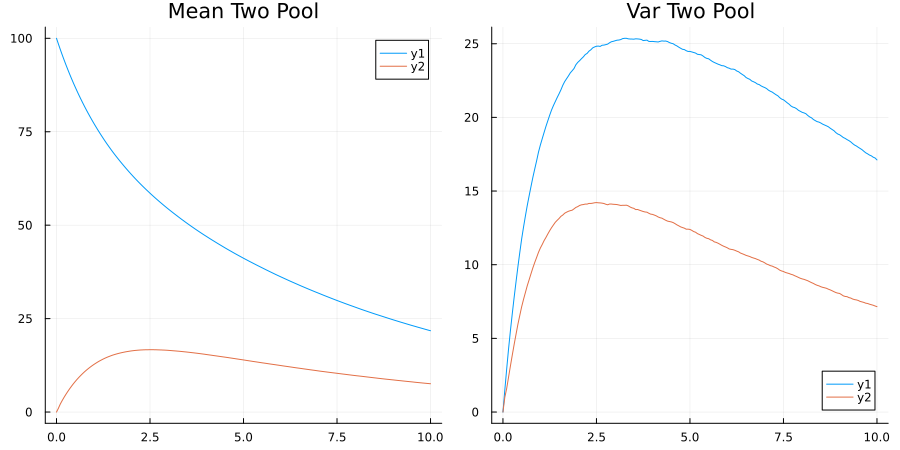

In [12]:
# plot ground truth
p_twopool_mean = plot(sol.u[1].t,truemean',title = "Mean Two Pool")
p_twopool_var = plot(sol.u[1].t,truevar', title = "Var Two Pool")

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)

# Define NNs for Reaction Fluxes and Forward Simulate with SDE

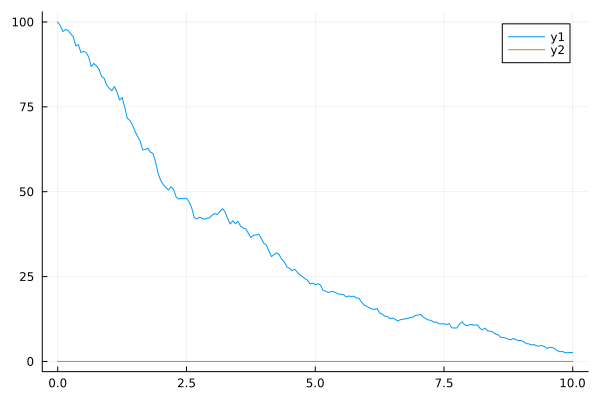

In [13]:
# NN: R^2 -> R^4, relu on final layer to force positive outputs
# ratesmodel = FastChain(FastDense(2 , 16, relu), FastDense(16 , 4, relu));
# p_nn = initial_params(ratesmodel);

# using Lux necessitates you to explicitly pass the states, `st`, into model run
# also note that two-pool model deals with partial observability of the system, so input is R^1, output still R^4
ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, relu));
p_nn, st = Lux.setup(Xoshiro(0), ratesmodel)

# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# # Old functions for Flux.jl
# function ratestodrift(u, p, t)
#     R1,R2,R3,R4 = ratesmodel(u,p,st)
#     return [
#         R4-(R1+R3),
#         R3-(R2+R4)
#     ]
# end

# function ratestodiff(u, p, t)
#     R1_r,R2_r,R3_r,R4_r = sqrt.(ratesmodel(u,p,st))
#     return [
#         R1_r 0.0 -R3_r R4_r;
#         0.0 R2_r R3_r R4_r
#     ]
# end

# updating rates from NNs function to deal with Lux framework better
# need to explicitly pass the states, and also need to extract the output at the first index (second index is NamedTuple)
# pass only partial state information, i.e., u[1] in two pool model
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,rebuild(p),st)[1]
    return [
        (R4*(u[2]>0)-(R1+R3)*(u[1]>0)),
        (R3*(u[1]>0)-(R2+R4)*(u[2]>0))
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = ratesmodel(u,rebuild(p),st)[1].^(1/2)
    return [
        R1_r*(u[1]>0) 0.0 -R3_r*(u[1]>0) R4_r*(u[2]>0);
        0.0 R2_r*(u[2]>0) R3_r*(u[1]>0) R4_r*(u[2]>0)
    ]
end

# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(p_nn)[1],
    noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')

In [14]:
# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# test zygote
# computing Jacobian instead of gradient (since output is multivariate)
# need to index to 1st element... since NamedTuple for structure of NN is 2nd element
# input to zygote must be flattened, input to ratesmodel must be rebuilt
# index zygote output to first index since zygote output is 1-tuple
res = Zygote.jacobian(p->ratesmodel(u_0,rebuild(p),st)[1],Flux.destructure(p_nn)[1])[1]

4×116 Matrix{Float64}:
 0.0  0.0  26.0569  44.9218   49.6919   …  0.0   0.0     1.0  0.0  0.0  0.0
 0.0  0.0  17.0491  30.8621   11.265       0.0   0.0     0.0  1.0  0.0  0.0
 0.0  0.0   0.0      0.0       0.0         0.0   0.0     0.0  0.0  0.0  0.0
 0.0  0.0  30.0881   6.06655   7.56537     0.0  55.0411  0.0  0.0  0.0  1.0

In [15]:
# p_nn_cat = []
# # println(fieldnames(typeof(p_nn)))
# # println(fieldnames(typeof(p_nn.layer_1)))
# for i in fieldnames(typeof(p_nn))
#     println(i)
#     for j in fieldnames(typeof(p_nn[i]))
#         println(p_nn[Symbol(i)][Symbol(j)])
#         p_nn_cat = vcat(p_nn_cat,vec(p_nn[Symbol(i)][Symbol(j)]))
#     end
# end
# # power (?) of named tuples
# # p_nn[:layer_1][:weight]
# p_nn_cat

# Backprop with Neural SDE

1. Cannot use callbacks since `setindex!` cannot be differentiated. :(
2. DO NOT USE `EnsembleProblem()` W/ ANY CODE MEANT TO BE AD'ed! IT WILL CRASH THE DAMN KERNEL!
3. `TrackerAdjoint()` as a sensealg is not working. Even on single SDE solve, it produces a gradient that is just bad with a whole lot of `NaN`s. Looking at documentation on sensitivity algs (https://docs.sciml.ai/SciMLSensitivity/stable/manual/differential_equation_sensitivities/#SciMLSensitivity.ReverseDiffAdjoint), it seems like Zygote-based and Tracker-based AD methods are simply overstated. `ForwardDiffSensitivity()` should work just fine, albeit it is very slowwwwwwww, and may even cause mismatch with the fact that we are calling a `Zygote.gradient` reverse-mode computed gradient when `ForwardDiffSensitivity()` is doing forward-mode AD to get the sensitivities.

In [77]:
function loss_neuralsde1(p,u=u_0,n=100)
    dt = 0.05
    tstops = length(range(tspan[1], step=dt, stop=tspan[2]))
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT)#, callback=cbs)
    res = map(
        (x->solve(prob, EM(), dt = dt, saveat = dt; save_everystep=false, sensealg=ForwardDiffSensitivity())),
        [u_0 for i in 1:n]
    )

    VA = VectorOfArray(res)
    arr = convert(Array,VA)
    means = mean(arr, dims = 3)
    vars = var(arr, dims = 3, mean = means)
    loss = sum(abs2, truemean .- means) + sum(abs2, truevar .- vars) + 1.0 * sum(abs2, p) + 1.0 * sum(abs, p) # elastic net without hyperparameters optimized
    
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=100
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
test_loss = loss_neuralsde1(flat)
# res = Zygote.gradient(p->loss_neuralsde(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde1(p,u_0,n),flat)

116-element Vector{Float64}:
      -2.019341230392456
      -1.103372484445572
  180261.97201454456
  310767.3141876216
  343767.0382758607
  -29721.644620475457
      -1.8944538831710815
 -117280.05989341345
      -1.2045346945524216
      -2.0862321853637695
  111077.4624247193
   55738.242343901635
      -1.6305271983146667
       ⋮
       1.8454792499542236
      -2.006476640701294
      -1.7279481291770935
       1.5751716494560242
  380313.57974146924
       1.446482092142105
      -1.227069929242134
       1.0001026415702654
   16992.26487652084
       1.0
       1.0
       1.0

# Simulate on full observability case (measuring both states)

In [88]:
# the ForwardDiff version of this optimization
# https://docs.sciml.ai/Optimization/stable/API/optimization_function/#Optimization.AutoForwardDiff
opt = ADAM(0.001)
losses = []
params_list = []
MAX_ITERS = 500 # around 36 seconds/iter on KKG comp, so ~5hrs for 500 iters

# save progress of solution, https://docs.sciml.ai/Optimization/stable/API/solve/#CommonSolve.solve-Tuple{OptimizationProblem,%20Any}
function callback(params,loss_val)
    
    # record round number and 
    println("Round $(length(params_list)) training loss: $(loss_val)")
    push!(losses,loss_val)
    push!(params_list,params)
    length(params_list) >= MAX_ITERS
end

# First round of training with n = 10
t1 = time_ns()
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde1(x), adtype)
optprob = Optimization.OptimizationProblem(optf, flat)
result1 = Optimization.solve(optprob, opt, maxiters = MAX_ITERS, callback=callback);
t2 = time_ns()
println("Total time elapsed: $((t2-t1)/1.0e9) seconds")

Round 0 training loss: 177102.40709784394
Round 1 training loss: 162703.74298953434
Round 2 training loss: 167607.27104279512
Round 3 training loss: 161038.97207723977
Round 4 training loss: 154910.40294100094
Round 5 training loss: 151614.54255787886
Round 6 training loss: 145565.9360215045
Round 7 training loss: 141837.60356356576
Round 8 training loss: 141717.38405468367
Round 9 training loss: 133481.84935724517
Round 10 training loss: 137032.05162387877
Round 11 training loss: 129421.43981079129
Round 12 training loss: 122412.8480890374
Round 13 training loss: 122170.5752854531
Round 14 training loss: 122761.05886813733
Round 15 training loss: 117311.27158796767
Round 16 training loss: 110056.89804850068
Round 17 training loss: 102023.53595838878
Round 18 training loss: 103073.23857469967
Round 19 training loss: 96813.48748662169
Round 20 training loss: 90139.79567493821
Round 21 training loss: 86294.1124555658
Round 22 training loss: 87474.67448061079
Round 23 training loss: 87011

Round 193 training loss: 63836.852860413586
Round 194 training loss: 61896.74348892963
Round 195 training loss: 61353.08193746589
Round 196 training loss: 62834.99687644887
Round 197 training loss: 65666.2990535766
Round 198 training loss: 62709.17498097883
Round 199 training loss: 61214.35716782458
Round 200 training loss: 64181.21281504188
Round 201 training loss: 64627.43783963052
Round 202 training loss: 63874.68997378573
Round 203 training loss: 62369.33510227572
Round 204 training loss: 63411.18453974913
Round 205 training loss: 63432.22327873667
Round 206 training loss: 62363.48334430026
Round 207 training loss: 62850.88896092144
Round 208 training loss: 63924.50301192268
Round 209 training loss: 63696.2317656621
Round 210 training loss: 64467.99799144396
Round 211 training loss: 61642.9232262132
Round 212 training loss: 64573.59146993585
Round 213 training loss: 63451.67093747418
Round 214 training loss: 64537.68425449886
Round 215 training loss: 62935.52126741813
Round 216 tra

Round 384 training loss: 65188.821702178306
Round 385 training loss: 64391.19115368848
Round 386 training loss: 68468.93773588524
Round 387 training loss: 66056.75846101866
Round 388 training loss: 61851.08181862091
Round 389 training loss: 61803.711053995285
Round 390 training loss: 62027.32918455973
Round 391 training loss: 62471.66189356546
Round 392 training loss: 62388.89007088737
Round 393 training loss: 61388.39622525015
Round 394 training loss: 64174.75233282321
Round 395 training loss: 61742.267196424684
Round 396 training loss: 62247.439101237935
Round 397 training loss: 62725.4470970392
Round 398 training loss: 64158.24993666618
Round 399 training loss: 66565.62537590225
Round 400 training loss: 62665.05421924652
Round 401 training loss: 62041.486673369734
Round 402 training loss: 62000.91161865856
Round 403 training loss: 62049.90220252848
Round 404 training loss: 63325.01086887039
Round 405 training loss: 62849.381534014195
Round 406 training loss: 63644.4187861173
Round 4

In [89]:
loss_neuralsde1(flat)

174356.00488489124

In [90]:
loss_neuralsde1(result1.u)

62764.80334858717

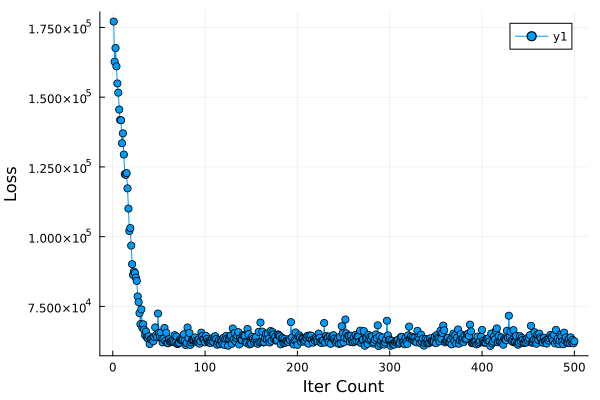

In [91]:
plot(1:MAX_ITERS,losses,ylabel = "Loss", xlabel = "Iter Count", markershape=:circle)

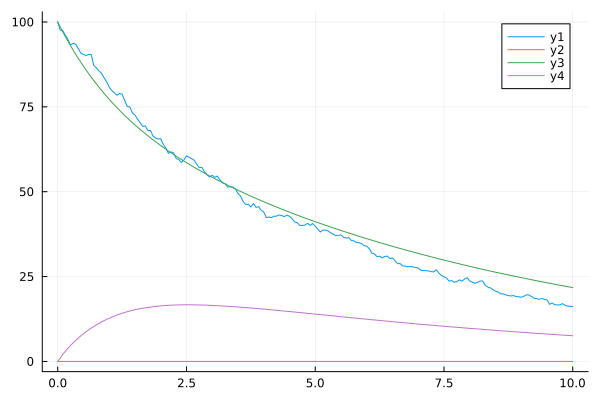

In [99]:
# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(result1.u)[1],
    noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')
plot!(sol.t,truemean')

# Looks like zero-ing out the rates is not desired, need callbacks for reflecting SDEs!

In [137]:
# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,true))
cbs = CallbackSet(cb_reflect)

# ground truth for two-pool model using ensemble of 100000 trajectories
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N, save_everystep=false)

# parse to remove failed simulations
parsed_sol_cb = [(sol.u[i].retcode != ReturnCode.Success ? nothing : sol.u[i]) for i in 1:length(sol.u)]
parsed_sol_cb = parsed_sol_cb[parsed_sol_cb.!=nothing]
truemean_cb = mean(parsed_sol_cb)[:,:]
truevar_cb = var(parsed_sol_cb)[:, :];

# number/proportion of failed simulations
println("$(N-length(parsed_sol_cb)) failed simulations, or $(1-length(parsed_sol_cb)/N)")

0 failed simulations, or 0.0


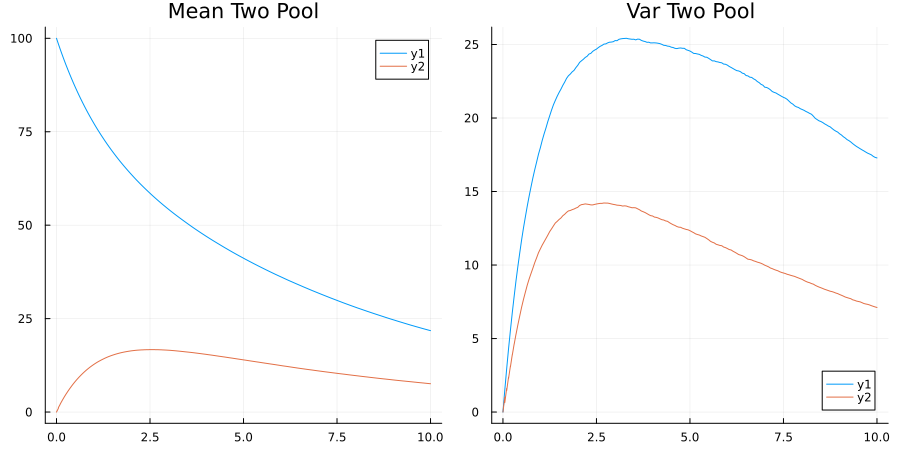

In [138]:
# plot ground truth
p_twopool_mean = plot(sol.u[1].t,truemean_cb',title = "Mean Two Pool")
p_twopool_var = plot(sol.u[1].t,truevar_cb', title = "Var Two Pool")

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)

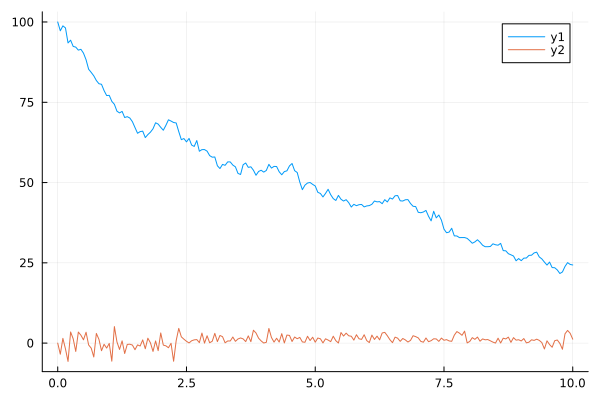

In [187]:
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,rebuild(p),st)[1]
    return [
        R4-(R1+R3),
        R3-(R2+R4)
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = ratesmodel(u,rebuild(p),st)[1].^(1/2)
    return [
        R1_r 0.0 -R3_r R4_r;
        0.0 R2_r R3_r R4_r
    ]
end

ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, relu));
p_nn, st = Lux.setup(Xoshiro(0), ratesmodel)

# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(p_nn)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')

# Trying to get SDE callback version to propagate adjoint appropriately

Suggestions to do `InterpolatingAdjoint()`. Has a couple of additional arguments to pass, see here: https://docs.sciml.ai/SciMLSensitivity/stable/manual/differential_equation_sensitivities/#SciMLSensitivity.InterpolatingAdjoint

When trying to set `autojacvec = ZygoteVJP` get the following error: only `ReverseDiffVJP` and `EnzymeVJP` are currently compatible with continuous adjoint sensitivity methods for hybrid DEs. Please select `ReverseDiffVJP` or `EnzymeVJP` as `autojacvec`.

Need to specify exactly where you are pulling `sensealg` from, e.g., `SciMLSensitivity.ReverseDiffVJP(true)`

### Testing for single SDE Problem: had to compromise and use ForwardDiff to compute gradients, frankschae suggested the step size for the SDE may be causing reverse-mode adjoint stability issues.

I'm trying to train a Neural SDE with non-diagonal noise where both the drift and diffusion terms are approximated by two dense layers w/ relu. I use `DiscreteCallback(condition,affect!;save_positions=(false,false))` to keep states positive (reflecting BC) and I run a batch of SDE solves to estimate moments on them (e.g., mean, var) in order to compute a loss against ground truth moments. 

What are the most robust reverse-mode AD `sensealg`s to use when using trying to compute gradients of such a loss function? Currently trying, for a single SDE solve:
1. `InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)` but getting a `BoundsError`
2. `TrackerAdjoint` was not working since `setindex!` is not differentiable
3. `BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)` was not working since giving flood of `NaN`s

Solution: remove `save_everystep=false`

In [189]:
# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

function loss_neuralsde4(p,u=u_0,n=2)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    sol = solve(prob, EM(), dt = dt, saveat = dt; sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)) #BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
    loss = sum(abs2,sol[:,:]) #sum(abs2, sol[:,:])
    return loss, sol
end

# manipulations of p_nn to get right structure and to train on the correct loss function
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
# test_loss = loss_neuralsde4(flat)[1]
test_res = loss_neuralsde4(flat)[2]

# res = ForwardDiff.gradient(p->loss_neuralsde4(p,u_0,n),flat)
# all NaNs when `DiscreteCallback(condition,affect!;save_positions=(false,true))`, 
# but BoundsError when `save_positions=(false,false)`
# res = Zygote.gradient(p->loss_neuralsde4(p,u_0,n)[1],flat)[1]
res = ForwardDiff.gradient(p->loss_neuralsde4(p, u_0, n)[1], flat)

116-element Vector{Float32}:
       0.0
       0.0
  -21133.537
 -500367.97
 -541650.44
  147912.25
       0.0
  555399.8
       0.0
       0.0
 -587167.75
   64833.305
       0.0
       ⋮
       0.0
       0.0
       0.0
       0.0
 -947363.06
   28106.371
       0.0
       1.0011771f6
  -27405.342
     648.6309
       0.0
   27731.072

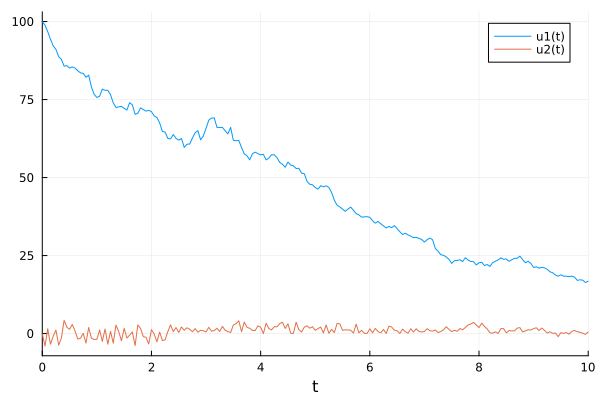

In [184]:
plot(test_res)

In [202]:
# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,true))
cbs = CallbackSet(cb_reflect)

function loss_neuralsde2(p,u=u_0,n=100)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    res = map(
        (x->solve(prob, EM(), dt = dt, saveat = dt; sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))),
        [u_0 for i in 1:n]
    )
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
    means = mean(arr, dims = 3)
    vars = var(arr, dims = 3, mean = means)
    loss = sum(abs2, truemean_cb .- means) + sum(abs2, truevar_cb .- vars) + 1.0 * sum(abs2, p) + 1.0 * sum(abs, p) # elastic net without hyperparameters optimized
    
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=2
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
test_loss = loss_neuralsde2(flat)
# res = Zygote.gradient(p->loss_neuralsde2(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde2(p,u_0,n),flat)

116-element Vector{Float64}:
      -2.019341230392456
      -1.103372484445572
  103633.61812416292
  430770.6948746349
  405743.9300145333
  -93241.58756895295
      -1.8944538831710815
 -190415.41189287184
   29103.851111979864
      -2.0862321853637695
  406820.3786804808
  -18775.627922505533
      -1.6305271983146667
       ⋮
       1.8454792499542236
      -2.006476640701294
      -1.7279481291770935
       1.5751716494560242
  748320.4723537278
   51489.351936765335
      -1.227069929242134
 -713927.4405199098
   35885.54834581242
    1240.799350462004
       1.0
  -33348.95208565309

# Do the training for non-zero ICs in each state

In [209]:
# new IC
u_0 = Float64[
    100.0,
    5.0
]

# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,true))
cbs = CallbackSet(cb_reflect)

# ground truth for two-pool model using ensemble of 100000 trajectories
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N, save_everystep=false)

# parse to remove failed simulations
parsed_sol_cb = [(sol.u[i].retcode != ReturnCode.Success ? nothing : sol.u[i]) for i in 1:length(sol.u)]
parsed_sol_cb = parsed_sol_cb[parsed_sol_cb.!=nothing]
truemean_cb = mean(parsed_sol_cb)[:,:]
truevar_cb = var(parsed_sol_cb)[:, :];

# number/proportion of failed simulations
println("$(N-length(parsed_sol_cb)) failed simulations, or $(1-length(parsed_sol_cb)/N)")

LoadError: InterruptException:

In [ ]:
# plot ground truth
p_twopool_mean = plot(sol.u[1].t,truemean_cb',title = "Mean Two Pool")
p_twopool_var = plot(sol.u[1].t,truevar_cb', title = "Var Two Pool")

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)

In [208]:
# the ForwardDiff version of this optimization
# https://docs.sciml.ai/Optimization/stable/API/optimization_function/#Optimization.AutoForwardDiff
opt = ADAM(0.001)
losses = []
params_list = []
MAX_ITERS = 20 # around 60 seconds/iter on KKG comp, so ~5hrs for 500 iters

# save progress of solution, https://docs.sciml.ai/Optimization/stable/API/solve/#CommonSolve.solve-Tuple{OptimizationProblem,%20Any}
function callback(params,loss_val)
    
    # record round number and 
    println("Round $(length(params_list)) training loss: $(loss_val)")
    push!(losses,loss_val)
    push!(params_list,params)
    length(params_list) >= MAX_ITERS
end

# First round of training with n = 10
# need to add a slight positive value to the IC to excite non-zero dynamics
t1 = time_ns()
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde2(x,u_0), adtype)
optprob = Optimization.OptimizationProblem(optf, flat)
result1 = Optimization.solve(optprob, opt, maxiters = MAX_ITERS, callback=callback);
t2 = time_ns()
println("Total time elapsed: $((t2-t1)/1.0e9) seconds")

Round 0 training loss: 250461.04851887375
Round 1 training loss: 256867.6002704196
Round 2 training loss: 305693.47690572066
Round 3 training loss: 237136.68024690205
Round 4 training loss: 262277.72097666207
Round 5 training loss: 250311.17971794022
Round 6 training loss: 205870.6996029594
Round 7 training loss: 261685.02008247667
Round 8 training loss: 249825.47034753836
Round 9 training loss: 219077.20050118535
Round 10 training loss: 324045.5307125738
Round 11 training loss: 255765.1389639245
Round 12 training loss: 259657.825414187
Round 13 training loss: 203112.23427978074
Round 14 training loss: 292647.20397568226
Round 15 training loss: 182479.19829477248
Round 16 training loss: 218078.39835685323
Round 17 training loss: 236776.43093892382
Round 18 training loss: 167968.07201333815
Round 19 training loss: 180421.68954290944
Total time elapsed: 565.7580221 seconds


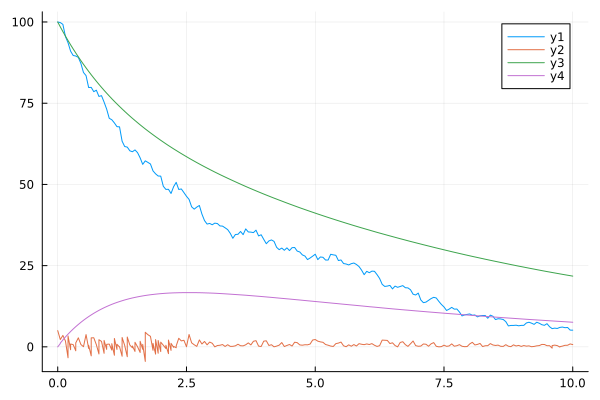

In [206]:
# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(result1.u)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
plot(sol.t, Array(sol)')
plot!(sol.t,truemean_cb')

# Simulate on partial observability case (measuring only first state)

WIP